## Project 3: Постановка задачи

Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить. Вам поставлена задача создать такую модель.

In [2]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from math import radians, cos, sin, asin, sqrt 
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

In [3]:
hotels = pd.read_csv('data/hotels.csv')
hotels.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [4]:
drop_col = []
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [5]:
# Заполняем пропущенные значения координат отелей
geolocator = Nominatim(user_agent="myapp")
no_coord_hotels = {
    'Austria Trend Hotel Schloss Wilhelminenberg Wien': 'Savoyenstrasse 2 Ottakring 1160 Vienna Austria',
    'Holiday Inn Paris Montmartre': '23 Rue Damremont 75018 Paris France',
    'Fleming s Selection Hotel Wien City': 'Josefstadter Strasse 10 Josefstadt 1080 Vienna Austria',
    'Hotel Atlanta': 'Wahringer Strasse 33 1090 Vienna Austria',
    'Maison Albar Hotel Paris Op ra Diamond': '4 Rue de la Pepiniere 75008 Paris France',   
    'Derag Livinghotel Kaiser Franz Joseph Vienna': 'Sieveringer Strasse 4 1190 Vienna Austria',
    'Hotel City Central': 'Taborstrasse 8 1020 Vienna Austria',
    'NH Collection Barcelona Podium': 'Bailen 4 6 Eixample 08010 Barcelona Spain',
    'City Hotel Deutschmeister': 'Grunentorgasse 30 1090 Vienna Austria',
    'Hotel Daniel Vienna': 'Landstrasser Gurtel 5 1030 Vienna Austria',
    'Roomz Vienna': 'Paragonstrasse 1 1110 Vienna Austria',
    'Hotel Pension Baron am Schottentor': 'Wahringer Strasse 12 1090 Vienna Austria',
    'Mercure Paris Gare Montparnasse': '71 Av du Maine 75014 Paris France',
    'Hotel Park Villa': 'Hasenauerstrasse 12 1190 Vienna Austria',
    'Hotel Advance': 'Sepulveda 180 Eixample 08011 Barcelona Spain',
    'Renaissance Barcelona Hotel': 'Renaissance Barcelona Hotel Barcelona Spain',
    'Cordial Theaterhotel Wien': 'Josefstadter Strasse 22/08 Josefstadt 1080 Vienna Austria'
    }
hotels_coord = {}
for i in hotels[hotels.lat.isna() == True].index:
    if hotels.loc[i,'hotel_name'] in hotels_coord.keys():
        hotels.loc[i, 'lat'] = hotels_coord[hotels.loc[i,'hotel_name']][0] 
        hotels.loc[i, 'lng'] = hotels_coord[hotels.loc[i,'hotel_name']][1]
    else:
        location = geolocator.geocode(no_coord_hotels[hotels.loc[i, 'hotel_name']])
        hotels.loc[i, 'lat'] = location.latitude
        hotels.loc[i, 'lng'] = location.longitude
        hotels_coord[hotels.loc[i,'hotel_name']] = [location.latitude, location.longitude]


## 1. Проектирование признаков
(Для экспресс анализа данных и выявления зависимостей пользуюсь библиотекой DTale)

In [6]:
# Создаем столбец со значением расстояния от отеля до центра города
def distance(La1, Lo1, La2, Lo2): 
    Lo1 = radians(Lo1) 
    Lo2 = radians(Lo2) 
    La1 = radians(La1) 
    La2 = radians(La2) 
    D_Lo = Lo2 - Lo1 
    D_La = La2 - La1 
    P = sin(D_La / 2)**2 + cos(La1) * cos(La2) * sin(D_Lo / 2)**2 
    Q = 2 * asin(sqrt(P)) 
    R_km = 6371 
    return round((Q * R_km),1)

hotels['city'] = hotels['hotel_address'].apply(lambda x: x.split()[-2] + ' ' + x.split()[-1] if x.split()[-1] != 'Kingdom' else x.split()[-5])

center_coord = {}
for city in hotels.city.value_counts().index:
    location = geolocator.geocode(city)
    center_coord[city] = (location.latitude, location.longitude)

distance_dict = {}
hotels['distance to city_center'] = ''
for i in hotels.index:
    h_name = hotels.loc[i,'hotel_name']
    if h_name in distance_dict.keys():
        hotels.loc[i, 'distance to city_center'] = distance_dict[h_name]
    else:
        dis = distance(hotels.loc[i, 'lat'], hotels.loc[i, 'lng'], center_coord[hotels.loc[i, 'city']][0], center_coord[hotels.loc[i, 'city']][1])
        hotels.loc[i, 'distance to city_center'] = dis
        distance_dict[h_name] = dis

hotels.drop('city', axis=1,  inplace=True)
hotels['distance to city_center'] =hotels['distance to city_center'].astype(float)


In [7]:
# Поскольку отели в странах распределены только по одному городу страны, географическую привязку сделаем только по одному признаку "страна" и проанализируем гипотезу
# о зависимости уровня средней оценки отеля от географической принадлежности

# Создадим признак "country_mean_score" - Средний рейтинг отелей в соответствуюшей стране

hotels['country'] = hotels['hotel_address'].apply(lambda x: x.split()[-1])
country_mean_score = hotels.groupby('country')['reviewer_score'].mean()
country_mean_score = dict(zip(country_mean_score.index, country_mean_score.values))
hotels['country_mean_score'] = hotels['country'].apply(lambda x: country_mean_score[x])

# Произведем нормализацию признаов 'country_mean_score'
#mm_scaler = preprocessing.MinMaxScaler()
#hotels['country_mean_score'] = mm_scaler.fit_transform(hotels[['country_mean_score']])

# Закодируем признак "страна" методом OneHot
encoder = ce.OneHotEncoder(cols=['country'])
type_bin = encoder.fit_transform(hotels['country'])
hotels = pd.concat([hotels, type_bin], axis=1)

drop_col.append('country')
drop_col.append('lat')
drop_col.append('lng')

Нормализация признака не дала прироста метрики

In [8]:
# Выделим из признака 'days_since_review' числовой параметр
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split()[0]))

In [9]:
# Создаим новые признаки дат: год, месяц, день
hotels['review_date']=pd.to_datetime(hotels['review_date'])
hotels['month']=pd.to_datetime(hotels['review_date']).dt.month
hotels['year']=pd.to_datetime(hotels['review_date']).dt.year
hotels['day']=pd.to_datetime(hotels['review_date']).dt.day
drop_col.append('review_date')

In [10]:
# Проанализируем зависимость уровня отзыва от количества слов в отзыве.
# 1. Для начала подкорректируем признак количества слов от содержания текстового отзыва

def correction(review):
    wrong_review = ('No Negative', 'N A', 'Nothing', 'nothing', 'No Positive', 'NA', 'Nope', 'NIL', 'na', 'Na', 'None', 'none', 'nil', 'Nil')
    if review in wrong_review:
        return 0
    review = list(map(lambda x: x.lower(), review.split()))
    if 'nothing' in review:
        return 0
    else:
        words_number = len(review)
        return words_number 
            
hotels['review_total_negative_word_counts'] = hotels['negative_review'].apply(correction)
hotels['review_total_positive_word_counts'] = hotels['positive_review'].apply(correction)

In [11]:
data_negative = hotels.groupby('review_total_negative_word_counts')['reviewer_score'].mean().round(4)
data_positive = hotels.groupby('review_total_positive_word_counts')['reviewer_score'].mean().round(4)

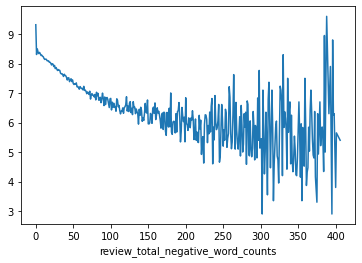

In [12]:
sns.lineplot(x=data_negative.index, y=data_negative.values,
             data=data_negative);

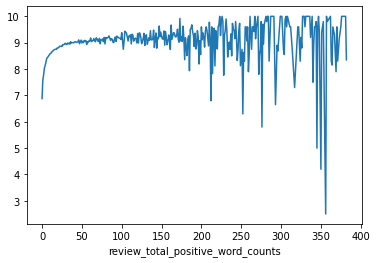

In [13]:
sns.lineplot(x=data_positive.index, y=data_positive.values,
             data=data_positive);

Из графиков видно, что с увеличением количества слов в отзыве, средний рейтинг отеля соответственно увеличивается либо уменьшается. Однако в отзывах длиной более 50 слов наблюдается существенное увеличение шума при соблюдении тенденции. 

In [14]:
# Сгладим шум в показателе среднего выставленного рейтинга в зависимости от длины текстового отзыва и создадим два новых признака:
# Средний рейтинг при негативном отзыве - 'mean_score_negative'"
# Средний рейтинг при позитивном отзыве - 'mean_score_pisitive'

def words_num_smooth(x):
    step = {70: 5, 120: 5, 180: 10, 250: 15, 320: 20, 420: 25}
    if x <= 30:
        return x
    for limit in step.keys():
        if x <= limit:
            return step[limit] * ((x // step[limit])+1)
 
    
hotels['negative_smooth'] = hotels['review_total_negative_word_counts'].apply(words_num_smooth)
data_negative = hotels.groupby('negative_smooth')['reviewer_score'].mean().round(4)
mean_score_negative = dict(zip(data_negative.index, data_negative.values))
hotels['mean_score_negative'] = hotels['negative_smooth'].apply(lambda x: mean_score_negative[x])

hotels['positive_smooth'] = hotels['review_total_positive_word_counts'].apply(words_num_smooth)
data_positive = hotels.groupby('positive_smooth')['reviewer_score'].mean().round(4)
mean_score_positive = dict(zip(data_positive.index, data_positive.values))
hotels['mean_score_positive'] = hotels['positive_smooth'].apply(lambda x: mean_score_positive[x])

drop_col.extend(['negative_smooth', 'positive_smooth', 'negative_review', 'positive_review'])

# Произведем нормализацию признаов 'mean_score_negative' и  'mean_score_positive'
#mm_scaler = preprocessing.MinMaxScaler()
#hotels[['mean_score_negative', 'mean_score_positive']] = mm_scaler.fit_transform(hotels[['mean_score_negative', 'mean_score_positive']])


Нормализация признаков не дала прироста метрики

In [15]:
# Закодируем признак "reviewer_nationality"
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, type_bin], axis=1)
drop_col.append('reviewer_nationality')

In [16]:
# Закодируем признак 'hotel_name'
bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['hotel_name'])
hotels = pd.concat([hotels, type_bin], axis=1)


In [17]:
# Проанализируем перечень тегов, создадим 40 признаком, соответствующих ТОР 40 встречающихся тегов, закодируем их методом One Hot
tags_dict = {}
for elem in hotels.tags:
    elem = list(map(lambda x: x[2:-2], elem[1:-1].split(', ')))
    for x in elem:
        tags_dict[x] = tags_dict.get(x, 0) +1
        
tags = pd.Series(tags_dict).sort_values(ascending=False).nlargest(40)
top_tags = tags.index
for elem in top_tags:
    hotels[elem] = hotels['tags'].apply(lambda x: 1 if elem in list(map(lambda a: a[2:-2], x[1:-1].split(', '))) else 0)

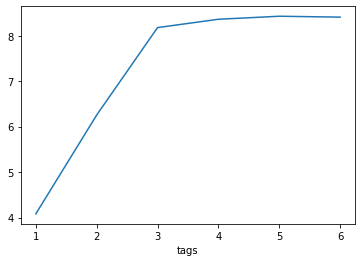

In [18]:
# Проанализируем зависисмость среднего выставленного рейтинга от количества тегов, отмеченных гостем и 
# создадим новый числовой признак - количество тегов

hotels['tags'] = hotels['tags'].apply(lambda x: len(x[1:-1].split(', ')))
data = hotels.groupby('tags')['reviewer_score'].mean()

sns.lineplot(x=data.index, y=data.values,
             data=data);

In [19]:
# Удаляем текстовые и ненужные признаки

obj_col = [elem for elem in hotels.columns if hotels[elem].dtypes == object]
drop_col.extend(obj_col)
hotels.drop(drop_col, axis = 1, inplace=True)

In [18]:
## Нормализация признаков не дала прироста метрики

#norm_cols = ['additional_number_of_scoring', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given','days_since_review']
#hotels[norm_cols] = mm_scaler.fit_transform(hotels[norm_cols])

In [20]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 81 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   tags                                        386803 non-null  int64  
 8   days_since_review                           386803 non-null  int64  
 9   distance to city_center                     386803 non-null  float64
 

## 2. Отбор признаков
### 2.1 Анализ мультиколлинеарности

<AxesSubplot: >

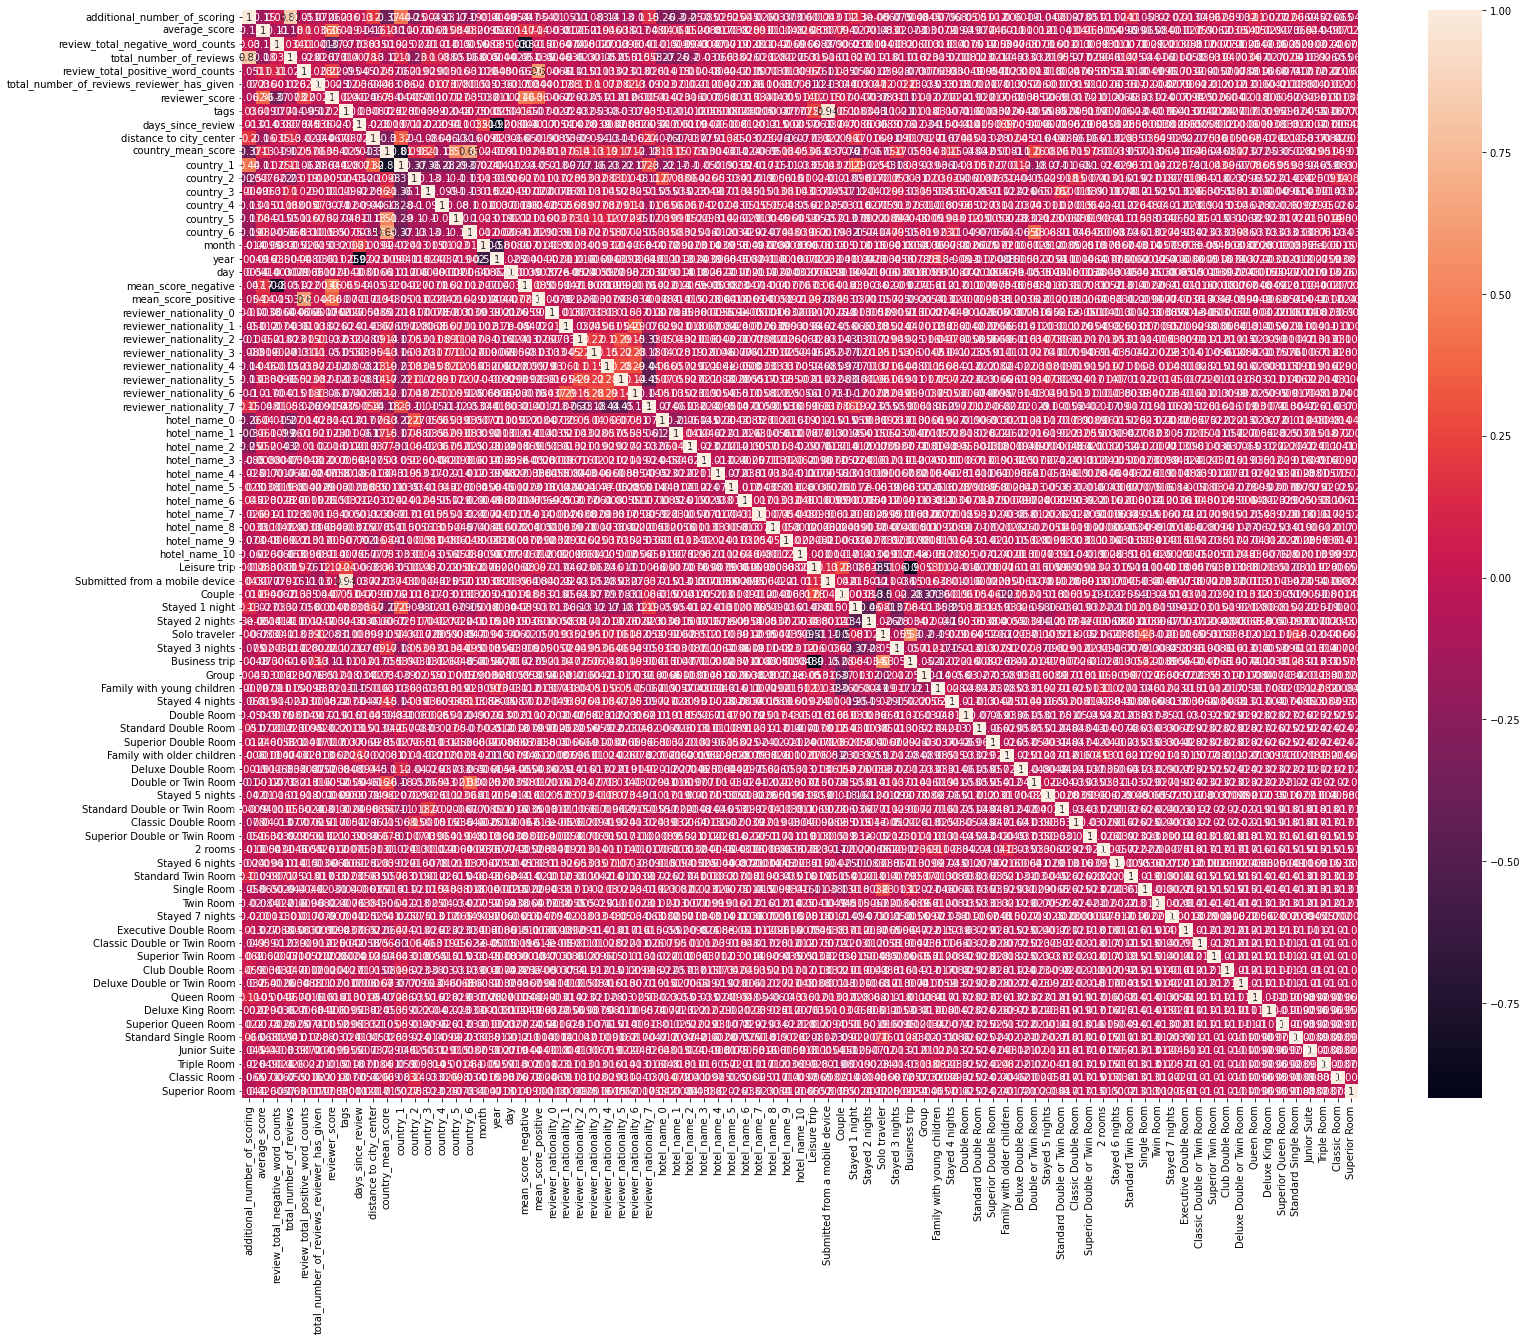

In [21]:
plt.rcParams['figure.figsize'] = (25,20)
sns.heatmap(hotels.corr(), annot=True)

In [21]:
# Удаляем признак с корееляцией больше 0,8

#hotels.drop(['total_number_of_reviews', 'year', 'country_mean_score', 'mean_score_negative'], axis=1, inplace=True)

Удаление коррелированных признаков не дало прироста метрики

In [22]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [23]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [24]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [25]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [26]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1367827122010486
